In [35]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import csv

# Dosyanın var olup olmadığını kontrol edin ve varsa silin
data_csv='Training/data.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"{data_csv} dosyası silindi.")
else:
    print(f"{data_csv} dosyası bulunamadı.")

data_csv='Training/dataset.csv'
data1_dir = 'Training'

# CSV dosyasının varlığını kontrol et

if os.path.exists(data_csv):
    print('exists')
else:
    data_dirs = [data1_dir]

    csv_file = 'Training/dataset.csv'
    data_csv = csv_file

    # Define the class mapping
    class_mapping = {
        'fire_images': 'Fire',
        'non_fire_images': 'NonFire',  
    }

    # Open the CSV file in write mode
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Write the header row

        # Iterate through the directories in the dataset directory
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Adjust file extensions as needed
                        # Get the image path
                        image_path = os.path.join(root, file)

                        # Extract the label from the parent folder name
                        label = os.path.basename(root)

                        # Apply the mapping to the label
                        mapped_label = class_mapping.get(label, label)

                        # Write the image path and mapped label to the CSV file
                        writer.writerow([image_path, mapped_label])
                        
    print(f"{csv_file} dosyası oluşturuldu.")

Training/data.csv dosyası bulunamadı.
Training/dataset.csv dosyası oluşturuldu.


In [36]:
data_csv

'Training/dataset.csv'

In [38]:
import pandas as pd
from keras.utils import to_categorical

# CSV dosyasını oku
data = pd.read_csv(data_csv)

# Resim boyutları
height, width = 224, 224

# Etiketleri değiştirme ve one-hot encoding işlemleri
def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))

In [40]:
from tensorflow.keras.preprocessing.image import load_img

# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3), dtype=np.float32)  # Veri tipini float32 olarak ayarladık
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Dosya yolunu al
    img = load_img(img_path, target_size=(height, width))  # Resmi yükle ve boyutlandır
    img_array = np.array(img) / 255.0  # Resmi numpy array'e çevir ve normalize et
    X[i] = img_array  # Array'i X'e ekle

print(X.shape)

(999, 224, 224, 3)


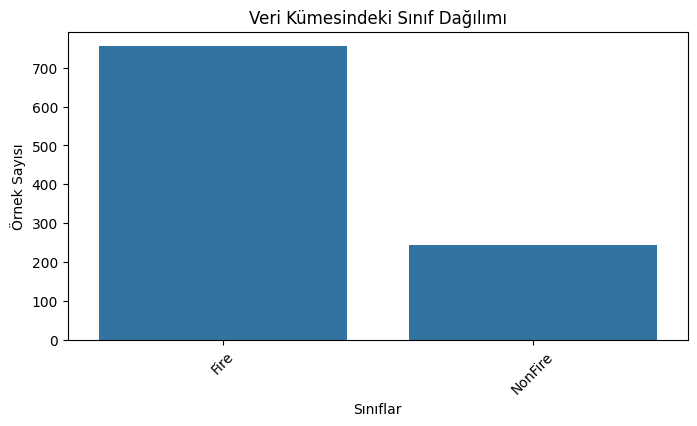

In [43]:
from matplotlib import pyplot as plt
import seaborn as sns

# Veri setindeki sınıf dağılımını görselleştirme
class_counts = data['label'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Sınıflar')
plt.ylabel('Örnek Sayısı')
plt.title('Veri Kümesindeki Sınıf Dağılımı')
plt.xticks(rotation=45)
plt.show()

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(699, 224, 224, 3)
(150, 224, 224, 3)
(150, 224, 224, 3)


In [46]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
# DenseNet121 modelini yükleme
tf.keras.backend.clear_session()
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: DenseNet121 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(densenet.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_densenet = Model(densenet.input, output)

# Modeli derleme
model_densenet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [47]:
history = model_densenet.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))


Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7624 - loss: 7.5145 - val_accuracy: 0.7267 - val_loss: 3846.1375
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9679 - loss: 0.0821 - val_accuracy: 0.7267 - val_loss: 2185.0122
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9934 - loss: 0.0263 - val_accuracy: 0.7467 - val_loss: 546.5845
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9727 - loss: 0.0761 - val_accuracy: 0.7867 - val_loss: 196.7826
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9928 - loss: 0.0259 - val_accuracy: 0.8400 - val_loss: 97.8771
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9596 - loss: 0.1514 - val_accuracy: 0.7267 - val_loss: 870.2728
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 112s 5s/step - accuracy: 0.9615 - loss: 0.0927 - val_accuracy: 0.7933 - val_loss: 75.9306
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - accuracy: 0.9863 - loss: 0.0304 - val_accuracy: 0.

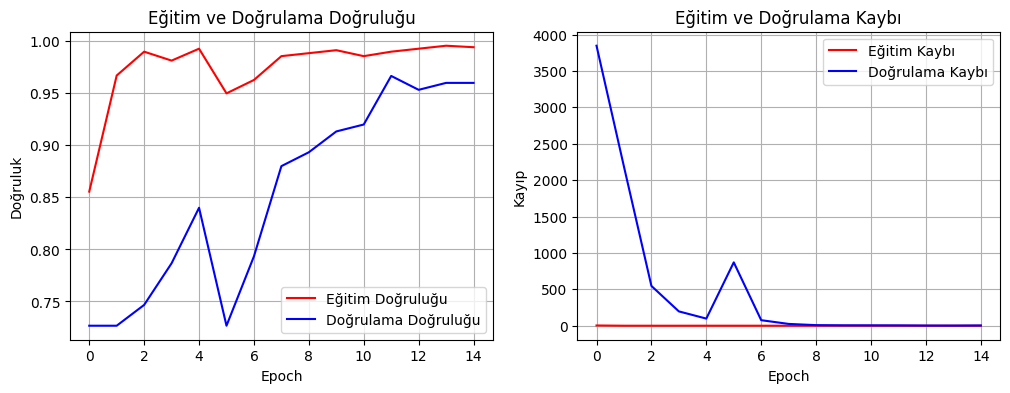

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 879ms/step


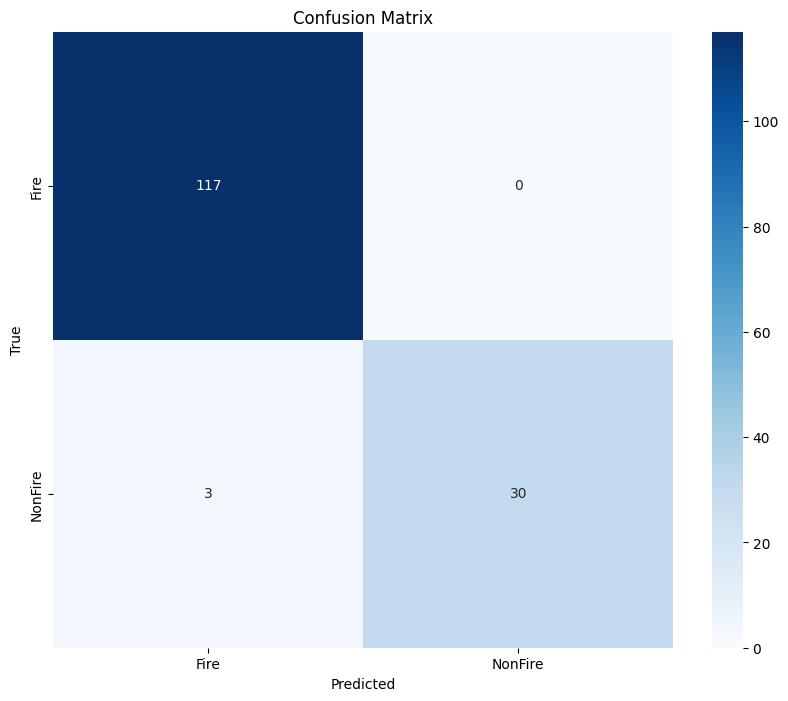

Precision: 0.9805
Recall: 0.9800
F1 Score: 0.9797
Test Accuracy: 0.9800


In [48]:
from sklearn.metrics import confusion_matrix

# Doğruluk ve kayıp grafiği
# Eğitim ve doğrulama doğruluğu ve kaybı grafikleri
plt.figure(figsize=(12, 4))

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu', color='red', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

# Eğitim ve doğrulama kaybı
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı', color='red', linestyle='-')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı', color='blue', linestyle='-')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.show()

# Test verisi üzerinden confusion matrix grafiği
y_pred = model_densenet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# Test verisi üzerinde metrikleri hesaplama
precision = precision_score(y_true_labels, y_pred_labels, average='weighted')
recall = recall_score(y_true_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
accuracy = accuracy_score(y_true_labels, y_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Test Accuracy: {:.4f}".format(accuracy))

In [49]:
model_densenet.save("model_yangin2.h5")

In [50]:
print(labels)


{'Fire': 0, 'NonFire': 1}
